In [79]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\SPAM text message 20170820 - Data.csv",delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [81]:
df.shape

(5572, 2)

In [82]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

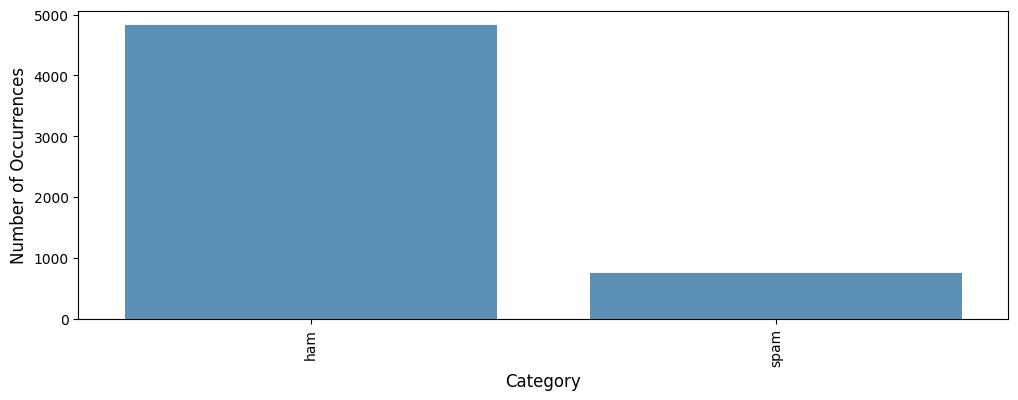

In [83]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [84]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Message: spam


In [85]:
print_message(1)

Ok lar... Joking wif u oni...
Message: ham


In [86]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 5572 unique tokens.


In [87]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [88]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['and', 'also', 'i', "'ve", 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'text', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed'], tags=['ham']),
       TaggedDocument(words=['mmm', 'thats', 'better', 'now', 'i', 'got', 'a', 'roast', 'down', 'me', '!', 'iâ\x92d', 'b', 'better', 'if', 'i', 'had', 'a', 'few', 'drinks', 'down', 'me', '2', '!', 'good', 'indian', '?'], tags=['ham']),
       TaggedDocument(words=['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha', '..', 'i', "'m", 'soryda', '..', 'realy', '..', 'frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

In [89]:
d2v_model = Doc2Vec(vector_size=20,dm=1,dm_mean=1,window=8,min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5571/5571 [00:00<?, ?it/s]


In [90]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5571/5571 [00:00<?, ?it/s]


CPU times: total: 250 ms
Wall time: 4.3 s


In [91]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [92]:
print(len(d2v_model.wv.key_to_index))

9412


In [93]:
vocab = {word: index for index, word in enumerate(d2v_model.wv.index_to_key)}


In [94]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

for word, i in vocab.items():
    embedding_vector = d2v_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [95]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)

[('0906346330', 0.7648481726646423),
 ('abta', 0.7471420764923096),
 ('sharing', 0.7427056431770325),
 ('09061213237', 0.7266827821731567),
 ('good.environment', 0.7058776021003723),
 ('reserve', 0.7032602429389954),
 ('having', 0.6979413628578186),
 ('aint', 0.689976692199707),
 ('pissed', 0.6890653967857361),
 ('448712404000', 0.6879040598869324)]

In [96]:
d2v_model.wv.most_similar(positive=['cherish'], topn=10)

[('okors', 0.7925320863723755),
 ('mojibiola', 0.7639785408973694),
 ('dawns', 0.759871244430542),
 ('wishin', 0.7256865501403809),
 ('regret', 0.7251994609832764),
 ('semester', 0.7162461280822754),
 ('given', 0.706733763217926),
 ('ultimatum', 0.6988664865493774),
 ('importantly', 0.6954418420791626),
 ('doesnâ\x80\x98t', 0.6926741003990173)]

In [97]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       188,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,260 (735.39 KB)

 Trainable params: 188,260 (735.39 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4736, 50) (4736, 2)
(836, 50) (836, 2)


In [99]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
148/148 - 2s - 16ms/step - acc: 0.8870 - loss: 0.3010
Epoch 2/50
148/148 - 1s - 9ms/step - acc: 0.9481 - loss: 0.1497
Epoch 3/50
148/148 - 1s - 9ms/step - acc: 0.9711 - loss: 0.0988
Epoch 4/50
148/148 - 1s - 9ms/step - acc: 0.9774 - loss: 0.0747
Epoch 5/50
148/148 - 1s - 9ms/step - acc: 0.9854 - loss: 0.0564
Epoch 6/50
148/148 - 1s - 9ms/step - acc: 0.9890 - loss: 0.0435
Epoch 7/50
148/148 - 1s - 9ms/step - acc: 0.9913 - loss: 0.0355
Epoch 8/50
148/148 - 1s - 9ms/step - acc: 0.9924 - loss: 0.0271
Epoch 9/50
148/148 - 1s - 9ms/step - acc: 0.9947 - loss: 0.0203
Epoch 10/50
148/148 - 1s - 9ms/step - acc: 0.9962 - loss: 0.0163
Epoch 11/50
148/148 - 1s - 9ms/step - acc: 0.9970 - loss: 0.0129
Epoch 12/50
148/148 - 1s - 9ms/step - acc: 0.9981 - loss: 0.0094
Epoch 13/50
148/148 - 1s - 9ms/step - acc: 0.9985 - loss: 0.0070
Epoch 14/50
148/148 - 2s - 10ms/step - acc: 0.9968 - loss: 0.0103
Epoch 15/50
148/148 - 2s - 11ms/step - acc: 0.9987 - loss: 0.0043
Epoch 16/50
148/148 - 2s - 12ms

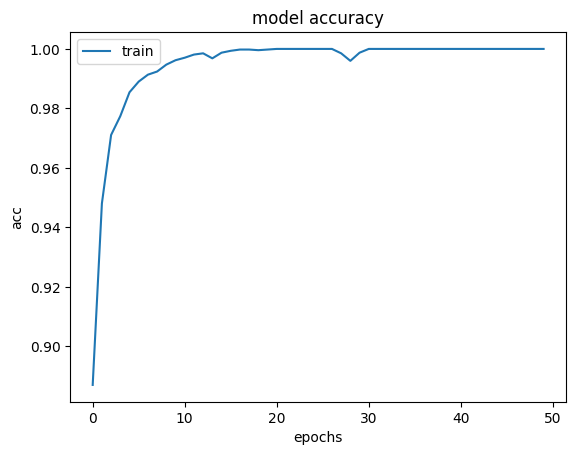

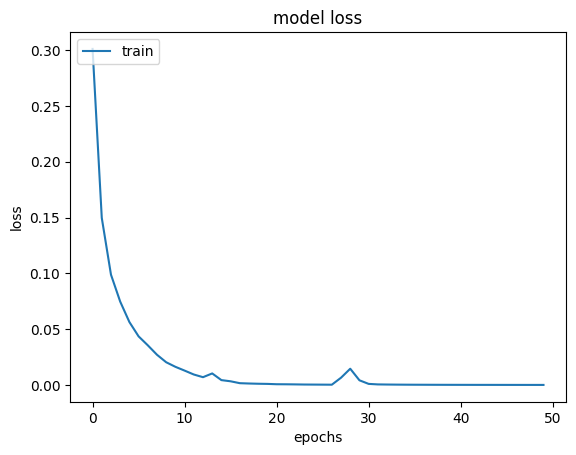

<Figure size 640x480 with 0 Axes>

In [100]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [101]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

148/148 - 1s - 4ms/step - acc: 1.0000 - loss: 3.6216e-05
27/27 - 0s - 9ms/step - acc: 0.9797 - loss: 0.1520
Train: 1.000, Test: 0.9797


In [102]:
# Predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print("Predicted probabilities:\n", yhat_probs)

# Convert probabilities to class predictions (0 or 1)
yhat_classes = (yhat_probs > 0.5).astype(int)
print("Predicted classes:\n", yhat_classes)

# Reduce to 1D array if necessary
# For binary classification, yhat_classes should already be 1D.
# In case of any specific shape issues, you can use:
yhat_probs = yhat_probs[:, 0]  # Assuming a single output neuron for binary classification
yhat_classes = yhat_classes[:, 0]  # Ensure yhat_classes is 1D if needed

print("Probabilities (1D):\n", yhat_probs)
print("Classes (1D):\n", yhat_classes)


Predicted probabilities:
 [[1.0000000e+00 5.9803060e-14]
 [1.0000000e+00 5.6285619e-11]
 [1.0000000e+00 2.8151304e-13]
 ...
 [1.0000000e+00 1.9765230e-15]
 [1.0000000e+00 9.2871037e-14]
 [1.0000000e+00 5.1575690e-14]]
Predicted classes:
 [[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
Probabilities (1D):
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 3.84483799e-11 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.05191038e-11 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 5.10259834e-10
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.12626367e-06 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.0000

In [103]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [104]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[  7, 722],
       [ 97,  10]], dtype=int64)

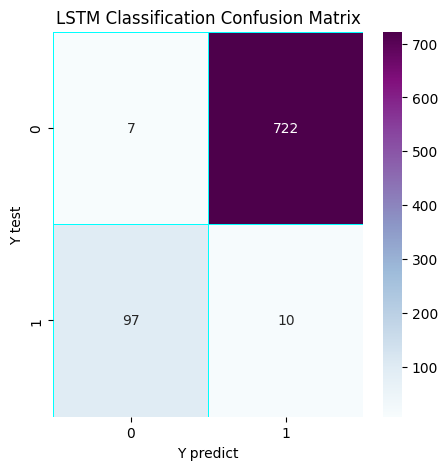

In [105]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [106]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9764 - loss: 0.1833
score: 0.17
acc: 0.98


In [107]:
model.save('Mymodel.h5')

In [108]:
message = ['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)]) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[1.0000000e+00 2.6091076e-13]] ham


In [110]:
message = ['Free entry in 2 a wkly comp to win FA Cup final..']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[5.597380e-06 9.999944e-01]] spam
